# ResGP Union
作者：Zhenjie Lu<br />
日期: 2024-8-11<br />

## 1.导入模块

In [1]:
import sys
import os
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.append(parent_dir)
import torch
import torch.nn as nn
import GaussianProcess.kernel as kernel
from FidelityFusion_Models.MF_data import MultiFidelityDataManager
import matplotlib.pyplot as plt

JITTER = 1e-6
EPS = 1e-10
PI = 3.1415

2.0.1+cu118


## 2.定义模型
ResGP的表达式可以表示为</br>
$$y^f (ξ)=∑_{k=1}^fr^k (ξ)(f=1,2,…,F)$$
$$r^f (ξ)= y^f (ξ)- y^{f-1}(ξ)   (f=2,3,…,F)$$
第𝑓精度的模型𝑓(𝜉)可以看作之前精度的残差项模型的累加，其中残差项$r^f (ξ)$是邻近的两个精度GP解之差,而Union的构造方式则是将非Union那种叠加精度的形式换成一种更加统一化的方法,类似于GP构建sigma的过程,只不过sigma的构建涉及到多个精度的kernel

In [2]:
class ResGP_union(nn.Module):
    
    def __init__ (self, fidelity_num, kernel_list):
        super().__init__()
        self.fidelity_num = fidelity_num
        self.kernel_list = nn.ModuleList(kernel_list)
    
    def forward(self, data_manager, x_test, fidelity_indicator = None, normal = False):
        
        if fidelity_indicator is not None:
            x_test = torch.cat([x_test.reshape(-1,x_test.shape[1]),(torch.tensor(fidelity_indicator)+1).reshape(-1,1)], dim = 1)
        
        to_fidelity = x_test[0,-1].int()
        
        x = []
        y = []
        x_num = 0
        for f in range(self.fidelity_num):
            x_f, y_f = data_manager.get_data(f, normal= normal)
            x_num += x_f.shape[0]
            x.append(x_f)
            y.append(y_f)
        x_train = x
        y_train = torch.cat(y, dim=0)
        
        Sigma = self.cal_Union_sigma(x_num, x_train)
        kx =  self.cal_union_kx(x_num, x_test.shape[0], x_train, x_test, to_fidelity)
        L = torch.linalg.cholesky(Sigma)
        LinvKx,_ = torch.triangular_solve(kx, L, upper = False)
        mean = kx.t() @ torch.cholesky_solve(y_train, L)
        var = self.cal_Union_sigma(x_test.shape[0], x_test) - LinvKx.t() @ LinvKx
        # var = var + self.log_beta.exp().pow(-1)
        
        return mean, var
            
    
    def negative_log_likelihood(self, x_train, y_train):
        
        x_num = 0
        for i in range(self.fidelity_num):
            x_num += x_train[i].shape[0]
        y_num, y_dimension = x_num , y_train.shape[1]
        
        Sigma = self.cal_Union_sigma(x_num, x_train) + JITTER * torch.eye(x_num)
        print(Sigma)
        
        eigenvalues, eigenvectors = torch.linalg.eig(Sigma)
        print("特征值:")
        print(eigenvalues)   
            
        L = torch.linalg.cholesky(Sigma)
        Gamma,_ = torch.triangular_solve(y_train, L, upper = False)
        nll =  0.5 * (Gamma ** 2).sum() +  L.diag().log().sum() * y_dimension  \
            + 0.5 * y_num * torch.log(2 * torch.tensor(PI)) * y_dimension
        return nll
    
    def cal_Union_sigma(self, x_num, x_train):
        
        Sigma = torch.zeros(x_num, x_num) ## sigma矩阵是一个对称方阵
        cur_row = 0  ##当前行
        cur_col = 0  ##当前列
        for f_r in range(self.fidelity_num):
            for f_c in range(f_r, self.fidelity_num):   ##处理对称方阵的右上三角部分
                x_f = x_train[f_r]
                x_c = x_train[f_c]
                xf_num = x_f.shape[0]
                xc_num = x_c.shape[0]
                
                if f_r == f_c and f_r == 0: ##最左上角的分块矩阵
                    Sigma[cur_row:cur_row+xc_num, cur_col:cur_col+xf_num] = self.kernel_list[0](x_f, x_c)
                elif f_r == f_c:  ##计算对角分块矩阵
                    Sigma[cur_row:cur_row+xc_num, cur_col:cur_col+xf_num] = self.kernel_list[0](x_f, x_c)
                    for i in range(f_r):
                        Sigma[cur_row:cur_row+xc_num, cur_col:cur_col+xf_num] +=  self.kernel_list[i+1](x_f, x_c)
                else: ##计算非对角分块矩阵，根据对称矩阵的性质得到下三角部分
                    continue
                    Sigma[cur_row:cur_row+xc_num, cur_col:cur_col+xf_num] = self.kernel_list[f_c](x_f, x_c)
                    Sigma[cur_col:cur_col+xf_num, cur_row:cur_row+xc_num] = Sigma[cur_row:cur_row+xc_num, cur_col:cur_col+xf_num].T
                cur_col += xc_num
            cur_row += x_train[f_r].shape[0]
            cur_col = cur_row    
            
        return Sigma
    
    def cal_union_kx(self, x1_num, x2_num, x_train, x_test, to_fidelity):
        kx = torch.zeros(x1_num, x2_num)
        cur_row = 0
        rho_num = to_fidelity
        for f_r in range(self.fidelity_num):  ##只有一竖向的分块矩阵
            x_f = x_train[f_r]
            xf_num = x_f.shape[0]
            if f_r == to_fidelity:
                kx[cur_row:cur_row+xf_num,0:x2_num] = self.kernel_list[0](x_f, x_test)
                for i in range(f_r):
                    kx[cur_row:cur_row+xf_num,0:x2_num] += self.kernel_list[i+1](x_f, x_test)
            elif f_r < to_fidelity:
                kx[cur_row:cur_row+xf_num,0:x2_num] = self.kernel_list[to_fidelity-1](x_f, x_test)
            else:
                kx[cur_row:cur_row+xf_num,0:x2_num] = self.kernel_list[rho_num](x_test, x_f)
                rho_num += 1
            cur_row += xf_num
        return kx

## 3.定义训练方法
ResGP Union的训练接口和GP类似

In [3]:
def train_ResGP_union(GPmodel, data_manager, max_iter=100, lr_init=1e-1, normal = False):
    optimizer = torch.optim.Adam(GPmodel.parameters(), lr = lr_init)
    for i in range(max_iter):
        optimizer.zero_grad()
        
        x = []
        y = []
        for f in range(GPmodel.fidelity_num):
            x_f, y_f = data_manager.get_data(f, normal = normal)
            x.append(x_f)
            y.append(y_f)
        y = torch.cat(y, dim=0)
        
        loss = GPmodel.negative_log_likelihood(x, y)
        loss.backward()
        optimizer.step()
        print('iter', i, 'nll:{:.5f}'.format(loss.item()), end='\r')
    print('',end='\n')

## 4.数据准备

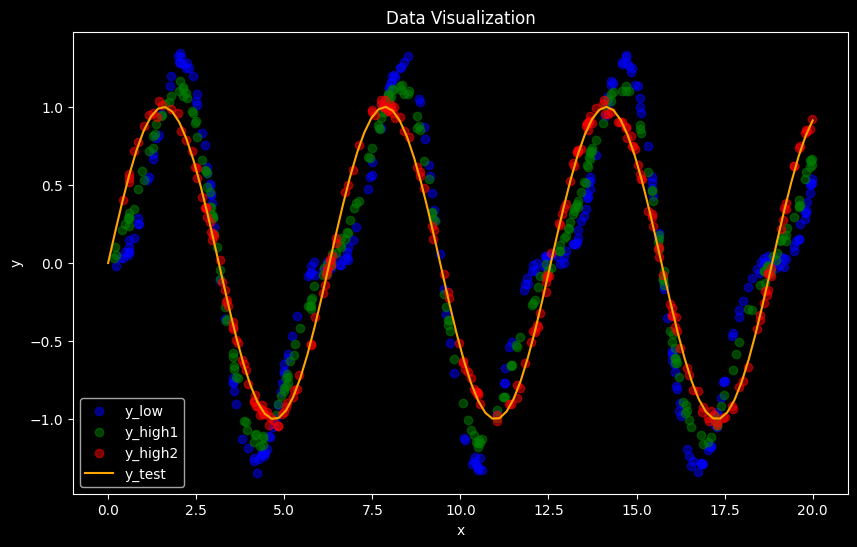

In [4]:
torch.manual_seed(1)
device = torch.device("cpu")

# generate the data
x_all = torch.rand(500, 1) * 20
xlow_indices = torch.randperm(500)[:300]
xlow_indices = torch.sort(xlow_indices).values
x_low = x_all[xlow_indices]
xhigh1_indices = torch.randperm(500)[:300]
xhigh1_indices = torch.sort(xhigh1_indices).values
x_high1 = x_all[xhigh1_indices]
xhigh2_indices = torch.randperm(500)[:250]
xhigh2_indices = torch.sort(xhigh2_indices).values
x_high2 = x_all[xhigh2_indices]
x_test = torch.linspace(0, 20, 100).reshape(-1, 1)

y_low = torch.sin(x_low) - 0.5 * torch.sin(2 * x_low) + torch.rand(300, 1) * 0.1 - 0.05
y_high1 = torch.sin(x_high1) - 0.3 * torch.sin(2 * x_high1) + torch.rand(300, 1) * 0.1 - 0.05
y_high2 = torch.sin(x_high2) + torch.rand(250, 1) * 0.1 - 0.05
y_test = torch.sin(x_test)

x_low = torch.cat((x_low, torch.zeros(x_low.shape[0], 1)), dim=1)
x_high1 = torch.cat((x_high1, torch.ones(x_high1.shape[0], 1)), dim=1)
x_high2 = torch.cat((x_high2, torch.full((x_high2.shape[0], 1), 2)), dim=1)
x_test = torch.cat((x_test, torch.full((x_test.shape[0], 1), 2)), dim=1)

plt.figure(figsize=(10, 6))
plt.scatter(x_low[:, 0].numpy(), y_low.numpy(), color='blue', label='y_low', alpha=0.5)
plt.scatter(x_high1[:, 0].numpy(), y_high1.numpy(), color='green', label='y_high1', alpha=0.5)
plt.scatter(x_high2[:, 0].numpy(), y_high2.numpy(), color='red', label='y_high2', alpha=0.5)
plt.plot(x_test[:, 0].numpy(), y_test.numpy(), color='orange', label='y_test')

plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Data Visualization')

plt.show()

## 5.初始化数据管理类

In [5]:
initial_data = [
        {'raw_fidelity_name': '0','fidelity_indicator': 0, 'X': x_low[:3].to(device), 'Y': y_low[:3].to(device)},
        {'raw_fidelity_name': '1','fidelity_indicator': 1, 'X': x_high1[:3].to(device), 'Y': y_high1[:3].to(device)},
        {'raw_fidelity_name': '2','fidelity_indicator': 2, 'X': x_high2[:3].to(device), 'Y': y_high2[:3].to(device)},
    ]
fidelity_num = len(initial_data)

fidelity_manager = MultiFidelityDataManager(initial_data)
kernel_list = [kernel.SquaredExponentialKernel() for _ in range(fidelity_num)]

## 6.实例化并训练模型

In [6]:
my = ResGP_union(fidelity_num = fidelity_num, kernel_list = kernel_list).to(device)

## if nonsubset is False, max_iter should be 100 ,lr can be 1e-2
train_ResGP_union(my, fidelity_manager, max_iter=200, lr_init=1e-2)

tensor([[7.3891e+00, 1.6835e-01, 1.0420e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.6835e-01, 7.3891e+00, 7.7367e-07, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.0420e-01, 7.7367e-07, 7.3891e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 1.4778e+01, 7.5323e-01, 3.3669e-01,
         0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 7.5323e-01, 1.4778e+01, 2.0911e-05,
         0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 3.3669e-01, 2.0911e-05, 1.4778e+01,
         0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         2.2167e+01, 2.1853e+01, 1.2874e-05],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         2.1853e+01, 2.2167e+0

C:\Users\ammle\AppData\Local\Temp\ipykernel_38676\2049709550.py:52: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\BatchLinearAlgebra.cpp:2197.)
  Gamma,_ = torch.triangular_solve(y_train, L, upper = False)


tensor([[1.4863, 0.4488, 0.3855, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4488, 1.4863, 0.0092, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3855, 0.0092, 1.4863, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 2.9478, 1.4456, 1.2010, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 1.4456, 2.9478, 0.1581, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 1.2010, 0.1581, 2.9478, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 4.7352, 4.7040, 0.1331],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 4.7040, 4.7352, 0.1581],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1331, 0.1581, 4.7352]],
       grad_fn=<AddBackward0>)
特征值:
tensor([2.0825+0.j, 0.8992+0.j, 1.4773+0.j, 4.9067+0.j, 1.1443+0.j, 2.7924+0.j, 9.4482+0.j,
        0.0311+0.j, 4.7263+0.j], grad_fn=<LinalgEigBackward0>)
tensor([[1.4634, 0.4366, 0.3745, 0.0000, 0.0000, 0.0000, 0.0000, 0.000

## 7.模型预测

c:\Users\ammle\anaconda3\envs\fan\lib\site-packages\matplotlib\axes\_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
c:\Users\ammle\anaconda3\envs\fan\lib\site-packages\matplotlib\axes\_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])


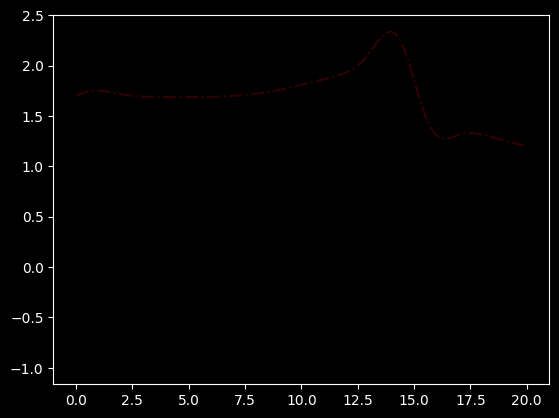

In [7]:
with torch.no_grad():
    ypred, ypred_var = my(fidelity_manager,x_test)
    
plt.figure()
plt.errorbar(x_test[:,0].flatten(), ypred.reshape(-1).detach(), ypred_var.diag().sqrt().squeeze().detach(), fmt='r-.' ,alpha = 0.2)
plt.fill_between(x_test[:,0].flatten(), ypred.reshape(-1).detach() - ypred_var.diag().sqrt().squeeze().detach(), ypred.reshape(-1).detach() + ypred_var.diag().sqrt().squeeze().detach(), alpha = 0.2)
plt.plot(x_test[:,0].flatten(), y_test, 'k+')
plt.show()